##### 🟡 Scenario 1: Moderately Imbalanced (Churn < 20%)

In [1]:
import mlflow
from mlflow.sklearn import log_model
from mlflow.models.signature import infer_signature
mlflow.set_experiment("Churn Prediction")

<Experiment: artifact_location='file:///c:/Users/Lay/projects/churn-prediction/notebooks/mlruns/247579898655627395', creation_time=1751150726419, experiment_id='247579898655627395', last_update_time=1751150726419, lifecycle_stage='active', name='Churn Prediction', tags={}>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    roc_curve,
    average_precision_score,
    f1_score,
    ConfusionMatrixDisplay
)

# Plot style
sns.set_theme(style="whitegrid")


In [ ]:
# load dataset with moderate churn rate
# df = pd.read_csv("../data/user_activity.csv")
# df.head()


,customer_id,signup_days_ago,last_active_days_ago,num_logins_last_month,avg_session_length,num_support_tickets,is_premium,churned
0,1,132,5,4,10.32,0,0,0
1,2,465,196,6,16.32,1,0,0
2,3,890,132,7,19.03,1,0,0
3,4,300,258,3,13.04,1,0,0
4,5,136,22,3,17.77,0,0,0


Simulate data from a master customer ID pool that is shared with other repos:

In [3]:
# Shared code to generate master customer IDs
np.random.seed(42)
n_customers = 1000  # total unique customers across both datasets

# Master customer ID pool
master_customer_ids = np.arange(1, n_customers + 1)

In [4]:
# Number of customers in churn dataset (e.g., 600)
n_churn_customers = 600

# Sample churn customers (random without replacement)
churn_customer_ids = np.random.choice(master_customer_ids, size=n_churn_customers, replace=False)

# Generate churn simulation for these customers (p=[0.8, 0.2] for textbook moderate churn)
np.random.seed(42)

df = pd.DataFrame({
    'customer_id': churn_customer_ids,
    'signup_days_ago': np.random.randint(30, 1000, size=n_churn_customers),
    'last_active_days_ago': np.random.randint(0, 300, size=n_churn_customers),
    'num_logins_last_month': np.random.poisson(5, size=n_churn_customers),
    'avg_session_length': np.round(np.random.normal(15, 5, size=n_churn_customers), 2),
    'num_support_tickets': np.random.poisson(0.5, size=n_churn_customers),
    'is_premium': np.random.choice([0, 1], size=n_churn_customers, p=[0.7, 0.3]),
    'churned': np.random.choice([0, 1], size=n_churn_customers, p=[0.8, 0.2])
})


In [5]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            600 non-null    int64  
 1   signup_days_ago        600 non-null    int32  
 2   last_active_days_ago   600 non-null    int32  
 3   num_logins_last_month  600 non-null    int32  
 4   avg_session_length     600 non-null    float64
 5   num_support_tickets    600 non-null    int32  
 6   is_premium             600 non-null    int64  
 7   churned                600 non-null    int64  
dtypes: float64(1), int32(4), int64(3)
memory usage: 28.3 KB


,customer_id,signup_days_ago,last_active_days_ago,num_logins_last_month,avg_session_length,num_support_tickets,is_premium,churned
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,484.788333,523.450000,147.781667,4.988333,14.848850,0.490000,0.291667,0.200000
std,286.829896,283.382039,87.358724,2.305151,5.015425,0.714669,0.454909,0.400334
min,1.000000,31.000000,0.000000,0.000000,1.130000,0.000000,0.000000,0.000000
25%,245.750000,271.750000,74.000000,3.000000,11.162500,0.000000,0.000000,0.000000
50%,478.500000,530.000000,145.500000,5.000000,15.050000,0.000000,0.000000,0.000000
75%,717.250000,772.500000,224.000000,7.000000,18.567500,1.000000,1.000000,0.000000
max,1000.000000,997.000000,299.000000,15.000000,29.600000,4.000000,1.000000,1.000000


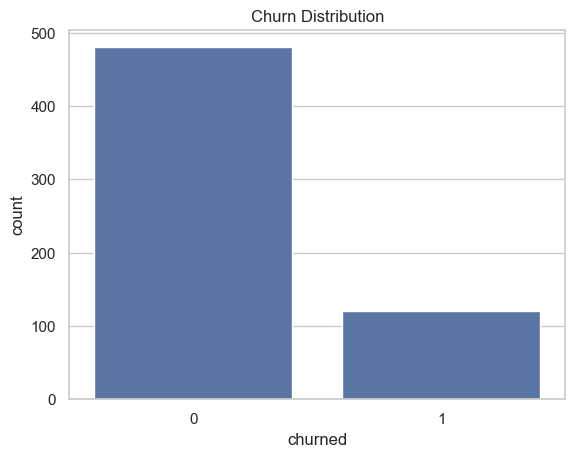

In [6]:
# Quick EDA

sns.countplot(x="churned", data=df)
plt.title("Churn Distribution")
plt.show()


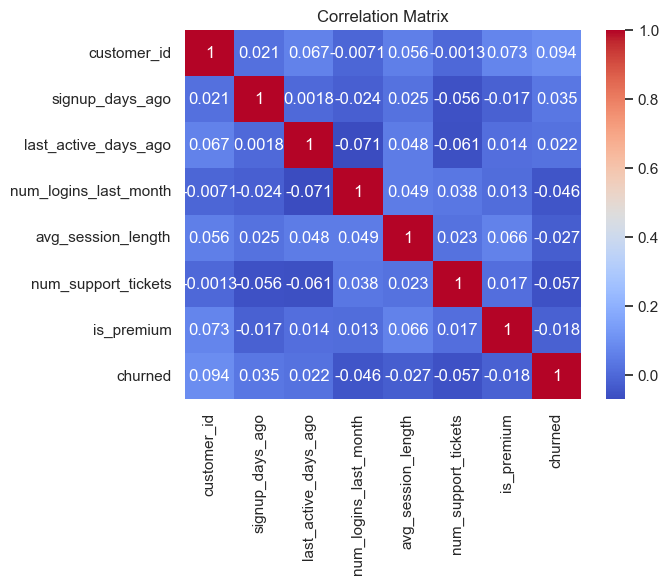

In [7]:
# check correlation

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [15]:
# feature prep

customer_ids = df["customer_id"] # useful for output export
X = df.drop(columns=["customer_id", "churned"])
y = df["churned"]

# Also split customer_ids to keep track of customers in train/test sets
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, customer_ids, test_size=0.2, stratify=y, random_state=42
)


✅ Recommended Baseline Model: Logistic Regression for good interpretability of the coefficients, balanced class weights to penalize mistakes on minority class (churn)

In [16]:
with mlflow.start_run(run_name="Moderate Imbalance - Logistic Regression"):
    model = LogisticRegression( 
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Logging params
    mlflow.log_param("scenario", "moderate")
    mlflow.log_param("dataset", "simulated")
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("churn_rate", round(y_train.mean(), 3))

    # Logging metrics
    mlflow.log_metric("precision", precision_score(y_test, y_pred, zero_division=0))
    mlflow.log_metric("recall", recall_score(y_test, y_pred, zero_division=0))
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba))

    # Define example input and schema
    example_input = X_test.iloc[:1].astype(np.float64)
    signature = infer_signature(X_train.astype(np.float64), model.predict(X_train))

    # Log the model with schema
    mlflow.sklearn.log_model(
        sk_model=model,
        name="model",
        input_example=example_input,
        signature=signature
    )


Model Evaluation:

In [17]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.50      0.59        96
           1       0.11      0.25      0.15        24

    accuracy                           0.45       120
   macro avg       0.42      0.38      0.37       120
weighted avg       0.60      0.45      0.50       120

Confusion Matrix:
 [[48 48]
 [18  6]]
ROC AUC: 0.44921875
Precision: 0.1111111111111111
Recall: 0.25
F1 Score: 0.15384615384615385


Use ROC AUC, F1, and confusion matrix to check early-stage model performance. PR AUC optional

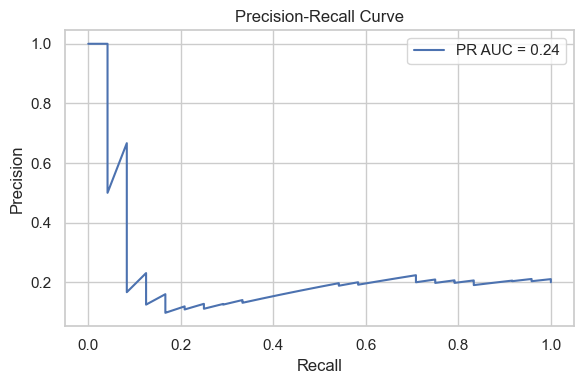

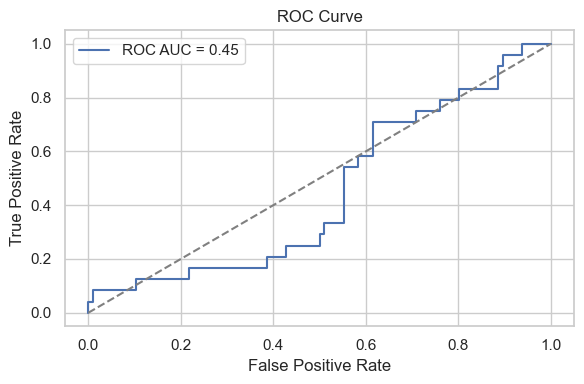

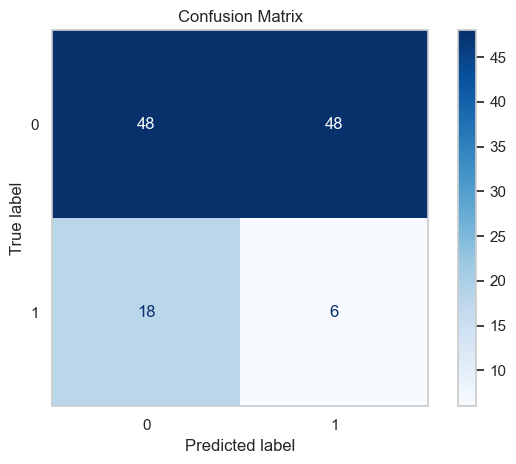

In [18]:
# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR AUC = {average_precision_score(y_test, y_proba):.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


🔧 __Optional: Adjust Threshold__  
If you want to manually set a threshold to be more aggressive catching churners:

In [19]:
y_pred_custom = (y_proba >= 0.3).astype(int)  # Lower threshold

print("Recall (threshold 0.3):", recall_score(y_test, y_pred_custom))


Recall (threshold 0.3): 1.0


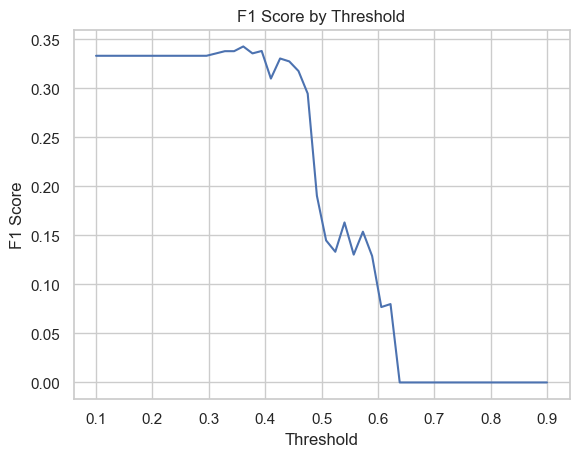

In [20]:
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_test, y_proba >= t) for t in thresholds]

plt.plot(thresholds, f1_scores)
plt.title("F1 Score by Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()


In [21]:
X_test_with_preds = X_test.copy()
X_test_with_preds["customer_id"] = ids_test.values  # reattach IDs
X_test_with_preds["churn_probability"] = y_proba
X_test_with_preds["churn_predicted"] = y_pred
X_test_with_preds["actual_churn"] = y_test.values  # optional

ordered_cols = ["customer_id", "churn_probability", "churn_predicted", "actual_churn"]
ordered_cols += [col for col in X_test_with_preds.columns if col not in ordered_cols]

X_test_with_preds = X_test_with_preds[ordered_cols]

X_test_with_preds.to_csv("../output/churn_predictions.csv", index=False)